# Murphy Diagrams

The Murphy diagram is a powerful tool for understanding how forecast performance differs for various user decision thresholds([Ehm *et al*., 2016](https://academic.oup.com/jrsssb/article/78/3/505/7040984?login=false))

Given many forecasts, the Murphy diagram shows the mean score for as a function of potential user decision thresholds $\theta$. It uses the relevant elementary score for the forecast, be it an
- expectile (e.g. mean)
- quantile (e.g. median)
- Huber quantile, or
- probabilistic forecast of a binary outcome.

For information about elementary scores, see the end of this tutorial. 

We'll use `scores` to create a Murphy diagram comparing two sets of synthetic temperature forecast data.

In [1]:
from scores.continuous import murphy_score, murphy_thetas, mse
import numpy as np
import xarray as xr
from scipy.stats import skewnorm
import matplotlib.pyplot as plt

np.random.seed(100)

In [ ]:
# Read the doc string for the murphy_score
help(murphy_score)

In [ ]:
# Read the doc string for murphy_thetas
help(murphy_thetas)

In [2]:
# Generate some synthetic observations between 0 and 40
N = 1000
obs = xr.DataArray(data=40 * np.random.random(N), dims=["time"], coords={"time": np.arange(0, N)})

# Generate synthetic forecasts by adding noise to each observation
fcst1 = 0.9 * obs + skewnorm.rvs(4, size=N) # fcst1 has a low bias and is unlikely to forecast outside 0 to 39
fcst2 = 1.1 * obs - skewnorm.rvs(4, size=N) # fcst2 has a high bias and forecasts colder than 0 and warmer than 40

Let's calculate the MSE for our two synthetic forecasts. 

In [3]:
print(f"MSE for fcst1 is {mse(fcst1, obs).item()}")
print(f"MSE for fcst2 is {mse(fcst2, obs).item()}")

MSE for fcst1 is 3.1974634143402207
MSE for fcst2 is 3.2106204909838336


As you can see, they are very similar. Next we will generate our murphy scores and plot them. To plot the Murphy Diagram for the mean, we choose "expectile" for the functional, and 0.5 for the $\alpha$

Text(0.5, 0.98, 'Murphy Score (for mean)')

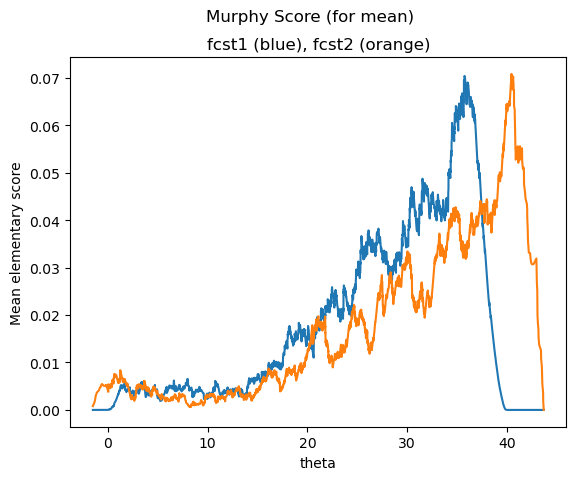

In [4]:
# Generate a list of thresholds of interest
thetas = murphy_thetas([fcst1, fcst2], obs, "expectile")

# Calculate the average elementary score for the mean (0.5 expectile) for each threshold theta
ms1 = murphy_score(fcst1, obs, thetas, "expectile", 0.5)
ms2 = murphy_score(fcst2, obs, thetas, "expectile", 0.5)

# Rename date variable for plotting
ms1 = ms1.rename({"total": "Mean elementary score"})
ms2 = ms2.rename({"total": "Mean elementary score"})

# Plot the results
ms1["Mean elementary score"].plot()
ms2["Mean elementary score"].plot()
plt.title('fcst1 (blue), fcst2 (orange)')
plt.suptitle('Murphy Score (for mean)')

- The horizontal shows the decision threshold $\theta$ (the temperature)
- The vertical axis shows the mean elementary score, sometimes interpreted as economic regret. 
- If you are only interested in whether it will be warmer or cooler than 20, compare the past performance of the two forecasts by reading the total at theta = 20.
- Lower totals are better.
- The area under the curve is proportional to the MSE. They have similar total area under the curves and similar MSEs.
- Forecast 1 (blue line) is clearly better for higher decision thresholds above 40 degrees, while Forecast 2 (orange line) is general better for users who care about decision thresholds between 5 and 35 degrees.
- One can imagine how constructing a scoring function by varying $H$ could lead to one forecast system being better than another.

**Things to try next**
- Try setting "decomposition" to True.
- Test it out for other functionals such as the median (also called the 0.5 quantile).
- Try it with n dimensional data
- Calculate the confidence that one forecast is better than another as a function of $\theta$ using the Diebold Mariano test statistic
- Read more about elementary scores below, and in the literature.

# **An introduction to elementary scores**

[Ehm, W., Gneiting, T., Jordan, A. and Krüger, F., 2016. Of quantiles and expectiles: consistent scoring functions, Choquet representations and forecast rankings. Journal of the Royal Statistical Society Series B: Statistical Methodology, 78(3), pp.505-562.](https://academic.oup.com/jrsssb/article/78/3/505/7040984?login=false)

The MSE is a consistent scoring function for forecasting the mean (also called the expected value or 0.5 expectile) of a predicitive distribution. But did you know that there is a whole family of proper scoring rules that are consistent for the mean?

[Savage (1971)](http://www.jstor.org/stable/2284229) showed that any function is consistent for the mean if and only if

$S(x, y) = \phi(y) - \phi(x) -\phi'(x)(y-x)$ where $x$ is the forecast value and $y$ is the observation, where $\phi$ is convex with subgradient $\phi'$

[Ehm et al. (2016)](https://academic.oup.com/jrsssb/article/78/3/505/7040984?login=false) showed that when a scoring function $S$ satisfies the above equation can be written as

$S(x, y) = \int_{-\infty}^{\infty} S_{\theta} (x, y) dH({\theta})$,

where $H$ is a non-negative measure, then

$ S_{\theta}(x, y) =  
	\begin{cases}
           |y-\theta |, &  \text{min}(x, y) \le \theta < \text{max}(x, y) \\
           0, & \text{otherwise}
	\end{cases},
$

is the elementary scoring function.

This means we can construct an infinite amount of different scoring rules that are consistent for forecasting the mean by varying $H$. All will be optimized by predicting the mean, but some will give more weighting to certain thresholds.

The Murphy diagram shows the average elementary score $S_{\theta}$ plotted across all potential user decision thresholds $\theta$. 

Different elemetary scoring functions are relevant to 
- different expectiles
- quantiles (e.g. median)
- Huber quantiles
- probabilistic forecasts of binary outcomes.